In [1]:
#import libraries
import re
import spacy

import pandas as pd

from collections import defaultdict
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

## Note - in order to use gensim, we must load the english language models. It's different depending on your OS:

In [18]:
# Windows
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Unix System (mac/ubuntu/etc.)
# nlp = spacy.load('en', disable=['ner', 'parser']) 


In [8]:
# load r/gameofthrones data
got_df = pd.read_csv('../data/gameofthrones.csv')

In [9]:
# view some of the data
got_df.head()

,Unnamed: 0,title,id,subreddit,body,comment,text
0,0,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,NaN,Make sure you [grab a house flair](https://www...,[Spoilers] Game of Thrones Season 8 | Official...
1,1,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,NaN,I wonder whether Jon is standing in front of N...,[Spoilers] Game of Thrones Season 8 | Official...
2,2,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,NaN,Wake me up on April 14 please. Thanks.,[Spoilers] Game of Thrones Season 8 | Official...
3,3,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,NaN,"""Our enemy doesn't stop, doesn't tire, doesn't...",[Spoilers] Game of Thrones Season 8 | Official...
4,4,[Spoilers] Game of Thrones Season 8 | Official...,axmpw7,gameofthrones,NaN,Everyone fighting and Cersei is just chilling ...,[Spoilers] Game of Thrones Season 8 | Official...


### How are we doing w.r.t. missing values?
Just to make sure everything worked, let's check the state of missing values in our data

In [10]:
got_df.isnull().sum()

Unnamed: 0         0
title              0
id                 0
subreddit          0
body          165902
comment           13
text               0
dtype: int64

It looks like the majority of posts dont have any data for `body`. This makes sense: some subreddits don't let you post a body if you're posting a link. We'll drop the missing comment data, since that'll be the basis for our analysis.

In [12]:
# remove rows with missing comments
got_df = got_df[pd.notnull(got_df['comment'])]

# make sure no missing comments
got_df.isnull().sum()

Unnamed: 0         0
title              0
id                 0
subreddit          0
body          165890
comment            0
text               0
dtype: int64

# Preprocess Text

In [25]:
def remove_stopwords(doc):
    txt = [token for token in doc if not token.is_stop]
    return txt

def lemmatize(doc):
    txt = [token.lemma_ for token in doc]
    return txt

def clean_text(doc, lem=True):
    # remove_stopwords
    txt = remove_stopwords(doc)
    # lemmatize
    if lem:
        txt = lemmatize(txt)
    # don't return text if it's too short
    if len(txt) > 2:
        return ' '.join(txt)

In [37]:
noise_tokens = ['com','a', 'www', 'ibb_co', 'r','s', 'b', 'ff', 'f', 'fc', 'cc', 'wiki', 'https', 'https_www', 'reddit_com', 'http', 'r_gameofthrone', 'c', 'jpg', 'gallery',
            'en_wikipedia', 'org', 'np_reddit', 'reddit_gameofthrone', 'policy', 'message', 'guide', 'reminder', 'delete', 'gameofthrone',
            'q', 'link', 'reddit_gameofthrone', 'v', 'comment', 'png', 'w', 'silver', 'gold', 'o', 'youtube_watch', 'post', 'imgur', 'reddit',
            'h', 'n', 'st', 'l', 'g', 'j', 'ibb', 'co', 'gif', 'k', 'gameofthrone', 'comment', 'post', 'x', 'subject',
            'info', 'compose', 'np']

# remove non-alphabetic characters & noise words
def filter_text(comment):
    # remove non-alpha characters
    alpha_comment = re.sub("[^A-Za-z']+", ' ', str(comment)).lower()
    # filter out bad words
    tokens = [word.lower() for word in alpha_comment.split() if word.lower() not in noise_tokens]
    return ' '.join(tokens)
brief_cleaning = (filter_text(row) for row in got_df['comment'])

In [38]:
brief_cleaning

<generator object <genexpr> at 0x000001BEB957F258>

In [39]:
%time
txt = [clean_text(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

Wall time: 0 ns


In [41]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(136434, 1)

In [42]:
sent = [row.split() for row in df_clean['clean']]

## Get Bigrams

In [43]:
bigram = Phrases(sent, min_count=30, progress_per=5000)

In [44]:
sentences = bigram[sent]

In [45]:
sentences

In [46]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

48503

In [47]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['think',
 'like',
 'know',
 'get',
 'jon',
 'good',
 'time',
 'go',
 'people',
 'book',
 'season',
 'look',
 'say',
 'thing',
 'want',
 'way',
 'love',
 'kill',
 'come',
 'see']

# word2vec training

In [49]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=7)

In [50]:
%%time
w2v_model.build_vocab(sentences, progress_per=10000)


Wall time: 0 ns


In [51]:
%%time
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


Wall time: 8min 20s


(20584963, 43820580)

In [52]:
# make model more memory efficient
w2v_model.init_sims(replace=True)

In [53]:
# play with model
w2v_model.wv.most_similar(positive=["stoneheart"])


[('lady_stoneheart', 0.619478702545166),
 ('lsh', 0.5528901815414429),
 ('resurrect', 0.5388072729110718),
 ('thoros', 0.5368763208389282),
 ('beric', 0.5333837270736694),
 ('revive', 0.5103162527084351),
 ('dondarrion', 0.5072036981582642),
 ('berric', 0.507118284702301),
 ('thoro', 0.4974755048751831),
 ('resurrection', 0.4882705807685852)]

In [54]:
w2v_model.wv.most_similar(positive=["kit"])

[('emilia', 0.5985122919082642),
 ('harrington', 0.5421903133392334),
 ('sophie', 0.5121541023254395),
 ('kit_harington', 0.49895262718200684),
 ('kit_harrington', 0.4639463424682617),
 ('maisie', 0.4636714458465576),
 ('liam_cunningham', 0.44022348523139954),
 ('rory', 0.4235354959964752),
 ('expressive', 0.4154559373855591),
 ('lena_heady', 0.4100172519683838)]

In [55]:
print(w2v_model.wv.similarity("jon", 'snow'))
print(w2v_model.wv.similarity("jon", 'lannister'))

0.25391802
0.23033652


In [56]:
print(w2v_model.wv.similarity("jon", 'kingslayer'))
print(w2v_model.wv.similarity("jaime", 'kingslayer'))

0.21379654
0.5630528


In [382]:
w2v_model.wv.doesnt_match(['jamie', 'tyrion', 'jon', 'tywin'])

'jon'

In [58]:
w2v_model.wv.doesnt_match(['sansa', 'arya', 'littlefinger'])

c:\users\jared.wilber\appdata\local\continuum\anaconda3\envs\athena\lib\site-packages\gensim\models\keyedvectors.py:858: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'arya'

In [59]:
w2v_model.wv.doesnt_match(['lannister', 'stark', 'greyjoy', 'tyrell'])

'greyjoy'

In [61]:
w2v_model.wv.most_similar(positive=["stark", "sexy"], negative=["stark"], topn=15)

[('hairy', 0.5148831009864807),
 ('bun', 0.46956121921539307),
 ('manly', 0.46892204880714417),
 ('hella', 0.4559461772441864),
 ('emma', 0.4306665062904358),
 ('attractive', 0.4265427887439728),
 ('combo', 0.39354991912841797),
 ('bleach', 0.3907240629196167),
 ('fabulous', 0.3867296278476715),
 ('cosplayer', 0.385781466960907),
 ('cosplaye', 0.38535475730895996),
 ('outfit', 0.3836440443992615),
 ('asian', 0.3834472894668579),
 ('cute', 0.38336920738220215),
 ('naturally', 0.3827199935913086)]

In [62]:
w2v_model.wv.most_similar(positive=["hodor", "bron"], topn=10)

[('hold_door', 0.5283201932907104),
 ('jojen', 0.41176626086235046),
 ('sam_gilly', 0.39575034379959106),
 ('pod', 0.3914218246936798),
 ('hodor_hodor', 0.38553208112716675),
 ('meera', 0.38212907314300537),
 ('bronn', 0.3816606402397156),
 ('willis', 0.3589194416999817),
 ('ex_machina', 0.35759615898132324),
 ('brienne_tarth', 0.352735310792923)]

In [78]:
%time
w2v_model.wv.most_similar(positive=["sad", "greyjoy"], topn=10)

Wall time: 0 ns


[('victarion', 0.49290987849235535),
 ('asha', 0.4251917004585266),
 ('balon', 0.42138567566871643),
 ('theon', 0.4074419140815735),
 ('yara', 0.3850886821746826),
 ('reek', 0.3712819218635559),
 ('favourite_character', 0.35579365491867065),
 ('arianne', 0.35482949018478394),
 ('redemption_arc', 0.350915789604187),
 ('drown', 0.3452707529067993)]

# t-sne

In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [80]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

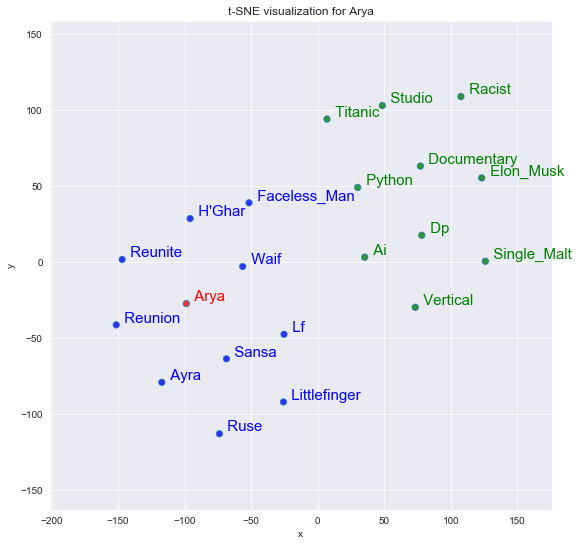

In [81]:
tsnescatterplot(w2v_model, 'arya', [i[0] for i in w2v_model.wv.most_similar(negative=["arya"])])

In [ ]:
bad_words = ['com', 'wiki', 'https', 'https_www', 'reddit_com', 'http', 'r_gameofthrone', 'c', 'jpg', 'gallery']

In [378]:
import difflib
def correct_name(first, second):
    return difflib.SequenceMatcher(first, first, second).ratio() > 0.05

first = ['barca', 'emstrdam', 'Praga']
second = ['New York', 'Amsterdam', 'Barcelona', 'Berlin', 'Prague']

result = [s for f in first for s in second if is_similar(f,s, 0.7)]
print(result)


['Amsterdam', 'Prague']
